In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
train_frame = train_frame.iloc[-1:]; test_frame = train_frame;

In [3]:
class TraceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = torch.tensor(train_frame.iloc[idx]['input'], dtype=torch.float32)
        target = torch.tensor(train_frame.iloc[idx]['target'], dtype=torch.float32)
        return input, target

train_dataset = TraceDataset(train_frame)
test_dataset = TraceDataset(test_frame)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [39]:
def bicycle_model_eval(input, last_pose):
    # This version takes in an input of dim 5
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    #states.append(torch.tensor([last_pose[0],last_pose[1],last_pose[2],input[0]], requires_grad=True))
    state = torch.zeros((4,))
    state[X] = last_pose[0]
    state[Y] = last_pose[1]
    state[THETA] = last_pose[2]
    state[V] = input[0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[1])) / L)
        state[V] = states[i-1][V] + TS*input[2]
        states.append(state)
        #states.append(
        #    torch.tensor(
        #        [states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA])),
        #         states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA])),
        #         states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[1])) / L),
        #         states[i-1][V] + TS*input[2]], requires_grad=True))
        #states[i, dX] = states[i-1,V] * torch.cos(trace[i-1,THETA])
        #states[i, dY] = states[i-1,V] * torch.sin(trace[i-1,THETA])
        #states[i, dTHETA] = (states[i-1,V] * torch.tan(input[4])) / L
        #states[i, dV] = input[5]
        #states[i, V] = states[i-1, V] + TS*states[i, dV]
    trace = torch.vstack(states)[1:,0:3]
    return trace


def custom_loss_func(prediction, target, output):
    loss = F.mse_loss(prediction, target)
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=10, target_size=3):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, target_size)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        output = torch.column_stack([F.softplus(output[:,0]), torch.tanh(output[:,1])*np.pi, output[:,2]])
        return output
    
    def predict(self, inputs, horizon=80):
        pass

In [40]:
net = LSTMPredictor()
net.load_state_dict(torch.load("best_simple_bicycle.pt"))

<All keys matched successfully>

In [41]:
torch.tensor(train_frame.iloc[0]['input'])

tensor([[-60.6901,  36.0461,   2.1413],
        [-60.8857,  36.3534,   2.1290],
        [-61.0805,  36.6594,   2.1432],
        [-61.2783,  36.9625,   2.1593],
        [-61.4817,  37.2603,   2.1914],
        [-61.6916,  37.5501,   2.2166],
        [-61.9060,  37.8312,   2.2389],
        [-62.1253,  38.1048,   2.2610],
        [-62.3492,  38.3738,   2.2763],
        [-62.5779,  38.6396,   2.2916]], dtype=torch.float64)

In [42]:
inp = torch.tensor(train_frame.iloc[0]['input'], dtype=torch.float32)
outp = net(inp)
target = torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32)
outp.shape

torch.Size([10, 3])

In [43]:
outp_trace = bicycle_model_eval(outp[-1], inp[-1])
from viz_net import make_dot

In [44]:
loss = custom_loss_func(outp_trace, target.squeeze(), outp[-1])
#g = make_dot(loss)
#g.view()

In [45]:
#g = make_dot(outp[-1])
#g.view()

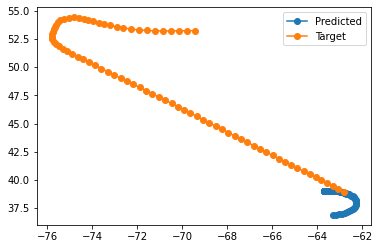

In [46]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:,0].detach().numpy(), target[:,1].detach().numpy(), marker='o', label='Target')
plt.legend()

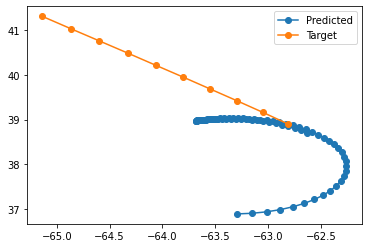

In [47]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:10,0].detach().numpy(), target[:10,1].detach().numpy(), marker='o', label='Target')
plt.legend()

In [48]:
torch.vstack([torch.rand((3,)) for _ in range(10)])

tensor([[0.5072, 0.7881, 0.8778],
        [0.6448, 0.9821, 0.0836],
        [0.7069, 0.0916, 0.7396],
        [0.6262, 0.0483, 0.4695],
        [0.0743, 0.4943, 0.6113],
        [0.8143, 0.2218, 0.9282],
        [0.0097, 0.0280, 0.0191],
        [0.1011, 0.4990, 0.8346],
        [0.0473, 0.2547, 0.4554],
        [0.3372, 0.7381, 0.9838]])

In [49]:
loss = nn.MSELoss()
loss(outp_trace,torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32))

tensor(71.2737, grad_fn=<MseLossBackward0>)

  0%|          | 0/1 [00:00<?, ?it/s]

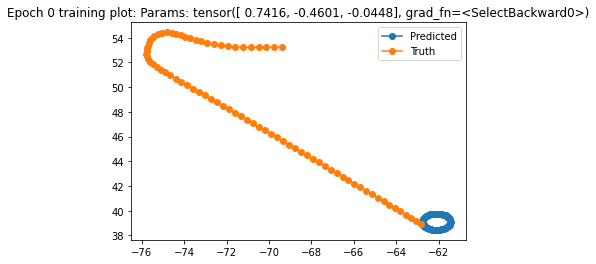

81.20100402832031


  0%|          | 0/1 [00:00<?, ?it/s]

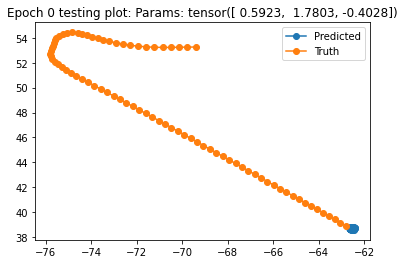

731.2990112304688
Epoch 0 | Train Loss: 81.20100402832031 | Test Loss: 731.2990112304688


  0%|          | 0/1 [00:00<?, ?it/s]

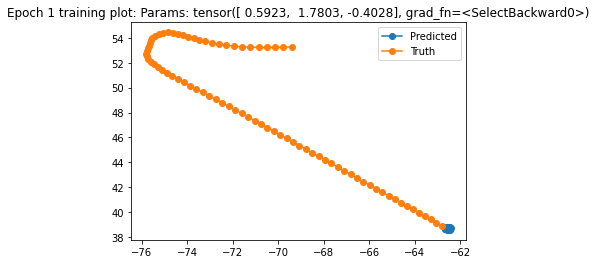

731.2990112304688


  0%|          | 0/1 [00:00<?, ?it/s]

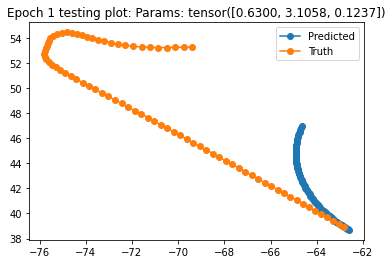

37.95244216918945
Epoch 1 | Train Loss: 731.2990112304688 | Test Loss: 37.95244216918945


  0%|          | 0/1 [00:00<?, ?it/s]

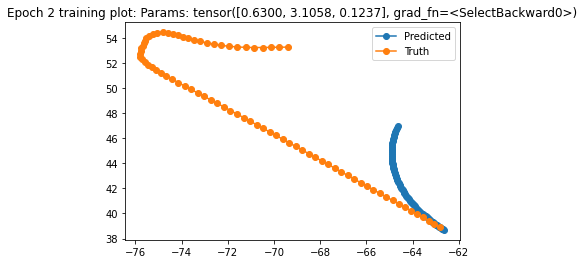

37.95244216918945


  0%|          | 0/1 [00:00<?, ?it/s]

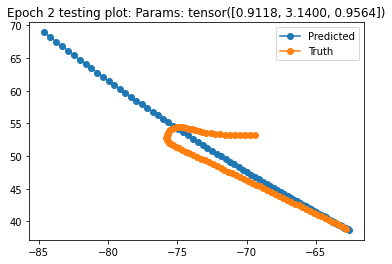

19.162641525268555
Epoch 2 | Train Loss: 37.95244216918945 | Test Loss: 19.162641525268555


  0%|          | 0/1 [00:00<?, ?it/s]

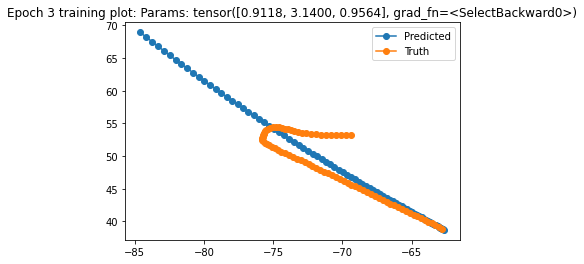

19.162641525268555


  0%|          | 0/1 [00:00<?, ?it/s]

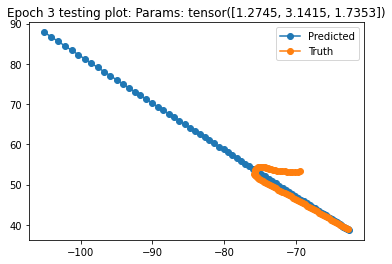

114.37740325927734
Epoch 3 | Train Loss: 19.162641525268555 | Test Loss: 114.37740325927734


  0%|          | 0/1 [00:00<?, ?it/s]

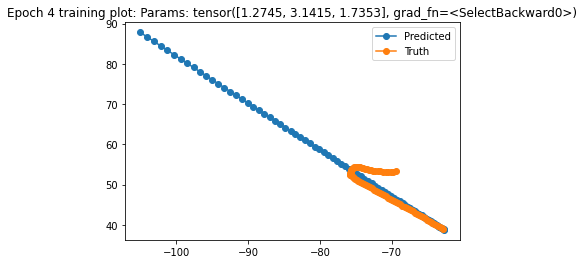

114.37740325927734


  0%|          | 0/1 [00:00<?, ?it/s]

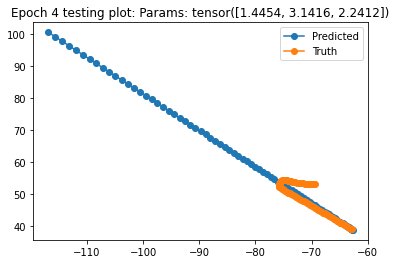

229.59994506835938
Epoch 4 | Train Loss: 114.37740325927734 | Test Loss: 229.59994506835938


  0%|          | 0/1 [00:00<?, ?it/s]

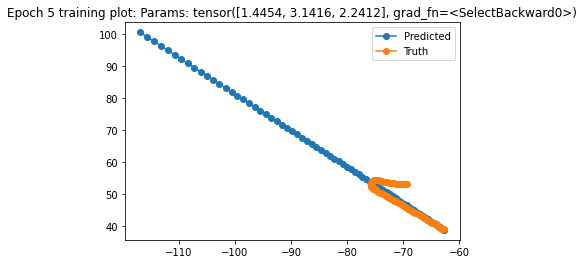

229.59994506835938


  0%|          | 0/1 [00:00<?, ?it/s]

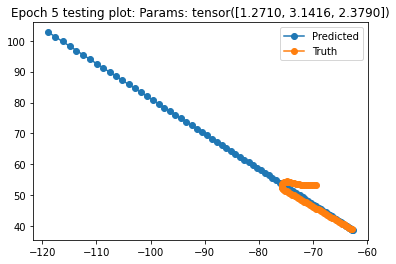

251.0520477294922
Epoch 5 | Train Loss: 229.59994506835938 | Test Loss: 251.0520477294922


  0%|          | 0/1 [00:00<?, ?it/s]

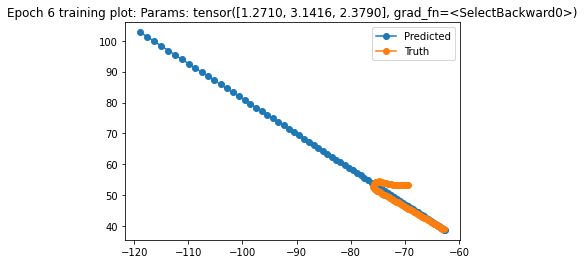

251.0520477294922


  0%|          | 0/1 [00:00<?, ?it/s]

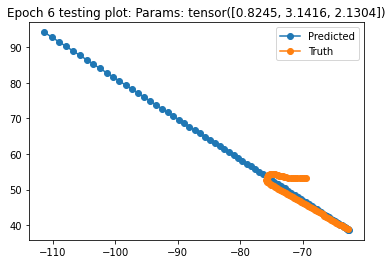

163.4553680419922
Epoch 6 | Train Loss: 251.0520477294922 | Test Loss: 163.4553680419922


  0%|          | 0/1 [00:00<?, ?it/s]

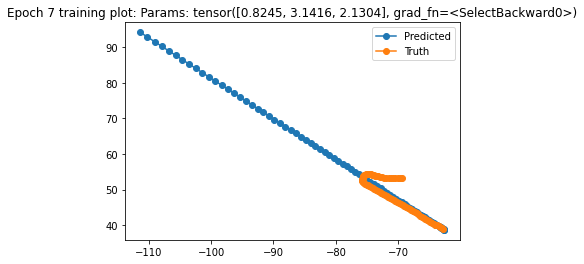

163.4553680419922


  0%|          | 0/1 [00:00<?, ?it/s]

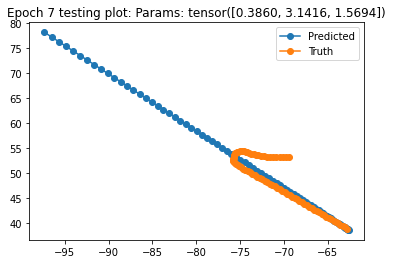

56.769168853759766
Epoch 7 | Train Loss: 163.4553680419922 | Test Loss: 56.769168853759766


  0%|          | 0/1 [00:00<?, ?it/s]

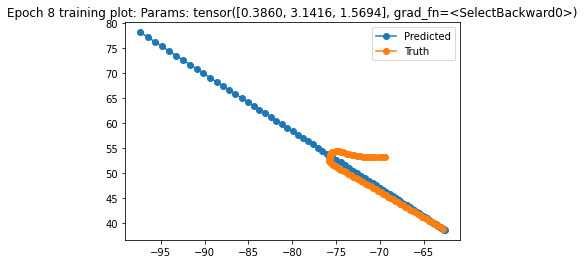

56.769168853759766


  0%|          | 0/1 [00:00<?, ?it/s]

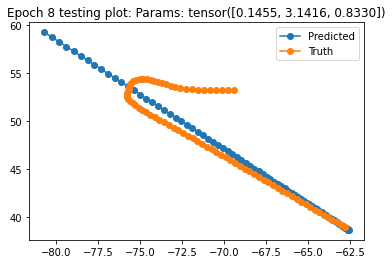

15.465487480163574
Epoch 8 | Train Loss: 56.769168853759766 | Test Loss: 15.465487480163574


  0%|          | 0/1 [00:00<?, ?it/s]

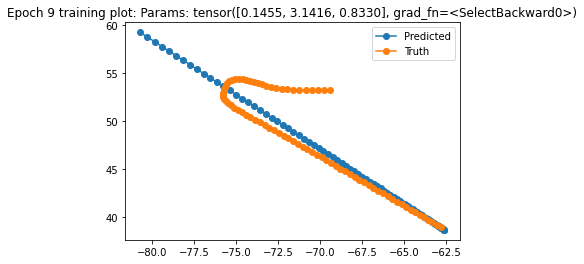

15.465487480163574


  0%|          | 0/1 [00:00<?, ?it/s]

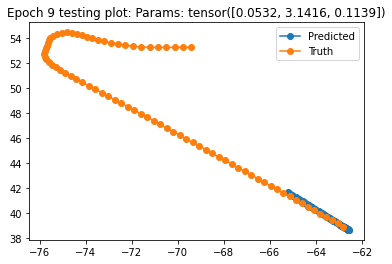

56.48279571533203
Epoch 9 | Train Loss: 15.465487480163574 | Test Loss: 56.48279571533203


  0%|          | 0/1 [00:00<?, ?it/s]

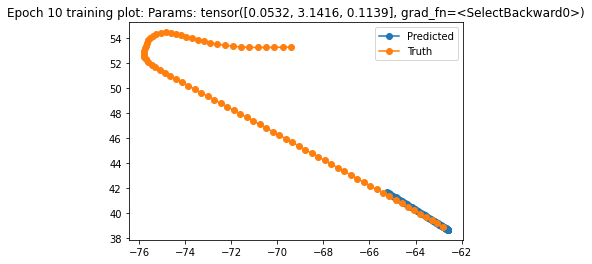

56.48279571533203


  0%|          | 0/1 [00:00<?, ?it/s]

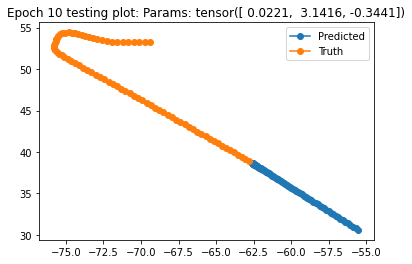

120.81175994873047
Epoch 10 | Train Loss: 56.48279571533203 | Test Loss: 120.81175994873047


  0%|          | 0/1 [00:00<?, ?it/s]

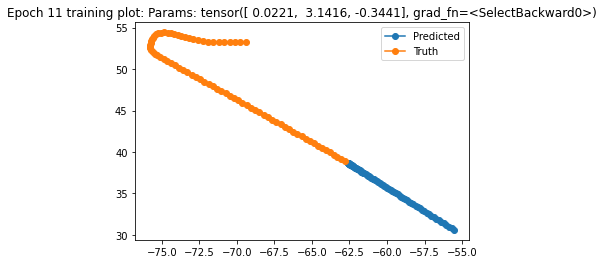

120.81175994873047


  0%|          | 0/1 [00:00<?, ?it/s]

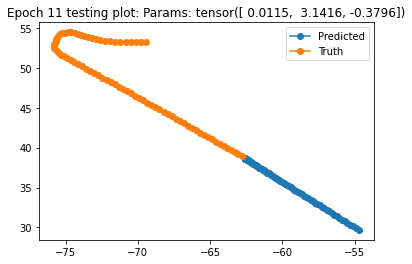

127.53899383544922
Epoch 11 | Train Loss: 120.81175994873047 | Test Loss: 127.53899383544922


  0%|          | 0/1 [00:00<?, ?it/s]

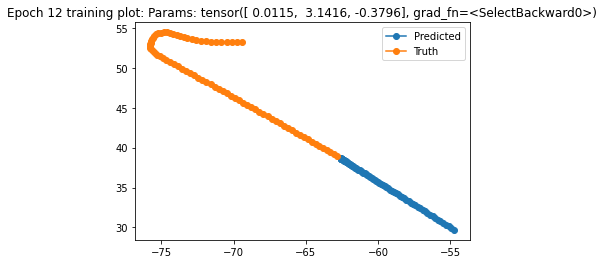

127.53899383544922


  0%|          | 0/1 [00:00<?, ?it/s]

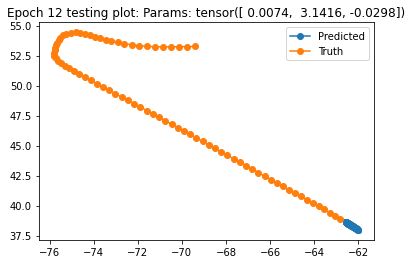

75.06525421142578
Epoch 12 | Train Loss: 127.53899383544922 | Test Loss: 75.06525421142578


  0%|          | 0/1 [00:00<?, ?it/s]

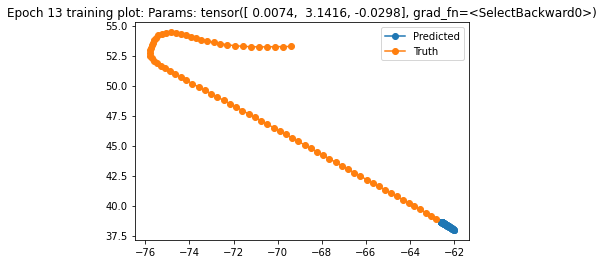

75.06525421142578


  0%|          | 0/1 [00:00<?, ?it/s]

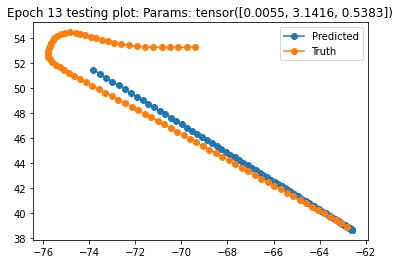

25.068063735961914
Epoch 13 | Train Loss: 75.06525421142578 | Test Loss: 25.068063735961914


  0%|          | 0/1 [00:00<?, ?it/s]

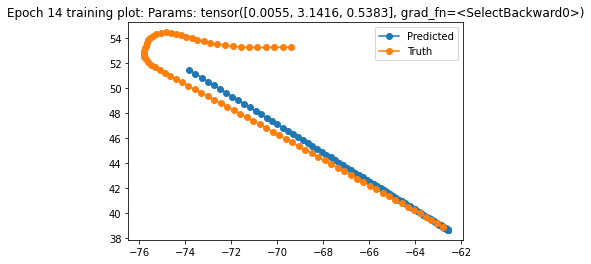

25.068063735961914


  0%|          | 0/1 [00:00<?, ?it/s]

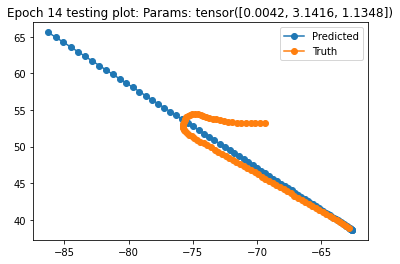

19.886398315429688
Epoch 14 | Train Loss: 25.068063735961914 | Test Loss: 19.886398315429688


  0%|          | 0/1 [00:00<?, ?it/s]

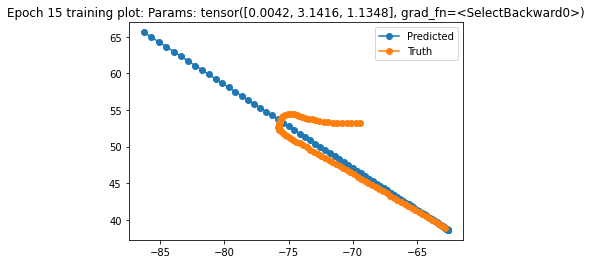

19.886398315429688


  0%|          | 0/1 [00:00<?, ?it/s]

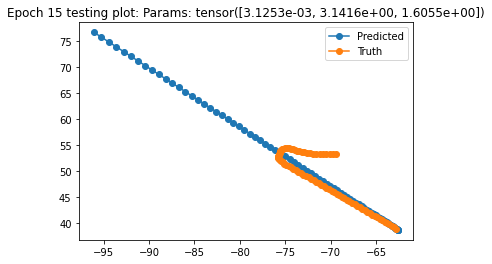

50.02863693237305
Epoch 15 | Train Loss: 19.886398315429688 | Test Loss: 50.02863693237305


  0%|          | 0/1 [00:00<?, ?it/s]

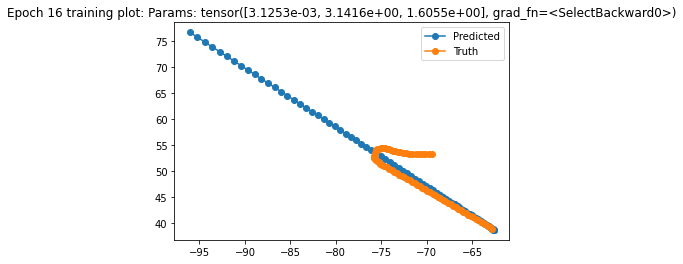

50.02863693237305


  0%|          | 0/1 [00:00<?, ?it/s]

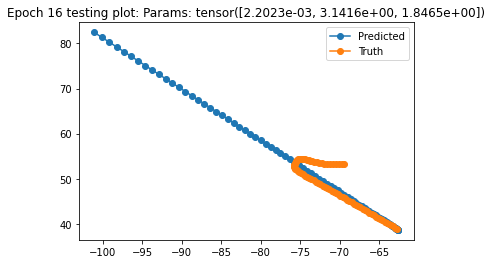

77.14164733886719
Epoch 16 | Train Loss: 50.02863693237305 | Test Loss: 77.14164733886719


  0%|          | 0/1 [00:00<?, ?it/s]

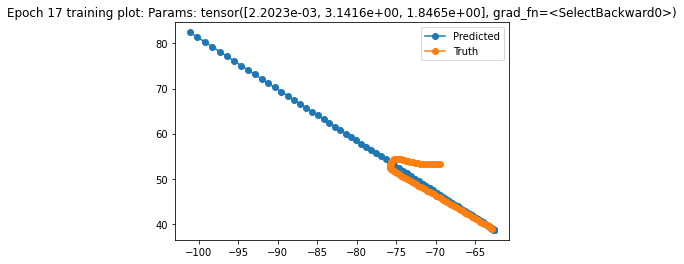

77.14164733886719


  0%|          | 0/1 [00:00<?, ?it/s]

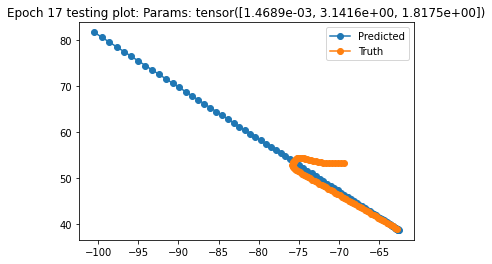

73.4371566772461
Epoch 17 | Train Loss: 77.14164733886719 | Test Loss: 73.4371566772461


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt



In [50]:
# Training Loop
torch.autograd.set_detect_anomaly(True)
net = LSTMPredictor()
net.to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)
train_losses = list()
test_losses = list()

for epoch in range(100):
    cum_train_loss = 0.0
    net.train()
    for input_data, target_data in tqdm(train_dataloader):
        net.zero_grad()
        input_data = input_data.squeeze().to(DEVICE)
        outp = net(input_data)
        outp = outp.squeeze()
        outp = outp.to("cpu")
        target_data = target_data.squeeze()
        #print(outp.shape)
        outp_trace = bicycle_model_eval(outp[-1], input_data[-1].detach().clone().to("cpu")).to(DEVICE)
        loss = custom_loss_func(outp_trace, target_data.squeeze().to(DEVICE), outp[-1])
        loss.backward()
        optimizer.step()
        cum_train_loss += loss.item()
    plt.title(f"Epoch {epoch} training plot: Params: {outp[-1]}")
    plt.plot(outp_trace[:,0].detach().cpu().numpy(), outp_trace[:,1].detach().cpu().numpy(), marker='o', label="Predicted")
    plt.plot(target_data[:,0].detach().cpu().numpy(), target_data[:,1].detach().cpu().numpy(), marker='o', label="Truth")
    plt.legend()
    plt.show()
    cum_train_loss /= len(train_dataset)
    train_losses.append(cum_train_loss)
    print(cum_train_loss)
    cum_test_loss = 0.0
    net.eval()
    with torch.no_grad():
        for input_data, target_data in tqdm(test_dataloader):
            input_data = input_data.squeeze().to(DEVICE)
            outp = net(input_data)
            outp = outp.squeeze()
            outp = outp.to("cpu")
            target_data = target_data.squeeze()
            outp_trace = bicycle_model_eval(outp[-1], input_data[-1].detach().clone().to("cpu")).to(DEVICE)
            loss = custom_loss_func(outp_trace, target_data.squeeze().to(DEVICE), outp[-1])
            cum_test_loss += loss.item()
        plt.title(f"Epoch {epoch} testing plot: Params: {outp[-1]}")
        plt.plot(outp_trace[:,0].detach().cpu().numpy(), outp_trace[:,1].detach().cpu().numpy(), marker='o', label="Predicted")
        plt.plot(target_data[:,0].detach().cpu().numpy(), target_data[:,1].detach().cpu().numpy(), marker='o', label="Truth")
        plt.legend()
        plt.show()
    cum_test_loss /= len(test_dataset)
    test_losses.append(cum_test_loss)
    if cum_test_loss <= min(test_losses):
        torch.save(net.state_dict(), "best_simple_bicycle.pt")
    print(cum_test_loss)
    print(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")

In [ ]:
plt.title(f"Learning Curves")
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(test_losses, marker='o', label="Testing Loss")
plt.legend()
plt.show()

In [ ]:
test_losses